In [76]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedShuffleSplit, RepeatedStratifiedKFold, GridSearchCV

Для ДЗ взят датасет https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease

In [77]:
df = pd.read_csv('Kidney_Decease.csv', sep=';')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      397 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

In [79]:
rows = df.shape[0]
cols = df.shape[1] - 1
numeric_rows = len(df.select_dtypes([np.number]).columns)

In [80]:
print(f'Анализ датасета после работы с признаками: {rows} наблюдений и {cols} признака, из которых {numeric_rows} - числовых, пропуски данных есть.')

Анализ датасета после работы с признаками: 400 наблюдений и 24 признака, из которых 14 - числовых, пропуски данных есть.


In [81]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [82]:
df.isnull().sum()

age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         3
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

Пропусков в данных досточно много, удалять наблюдения с пропусками нецелесообразно - останется мало наблюдений, будем заполнять пробелы:

In [83]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


Пропуски в числовых признаках заменяем их средними значениями для каждого класса (медианы почти совпадают со средними значениями, т.е. выбросов практически нет), для категориальных признаков с большим количеством пропусков создаем отдельный класс 'unknown', остальные наблюдения с маленьким количеством пропусков удаляем:

In [84]:
for feature in list(df.select_dtypes([np.number]).columns):
    df[feature] = df[feature].fillna(df.groupby('class')[feature].transform('mean'))
df['rbc'].fillna(value='unknown',inplace=True)
df['pc'].fillna(value='unknown',inplace=True)
df.dropna(inplace=True)
rows = df.shape[0]
cols = df.shape[1] - 1

In [85]:
df.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

Пропуски в данных устранены

In [86]:
df['class'].value_counts()

ckd       250
notckd    142
Name: class, dtype: int64

In [87]:
print(f'Анализ датасета после работы с признаками: {rows} наблюдений и {cols} признака.')

Анализ датасета после работы с признаками: 392 наблюдений и 24 признака.


In [88]:
print(f'Датасет содержит наблюдения за пациентами с почечной недостаточностью, в наблюдениях {df["class"].value_counts()[0]} случаев с диагностированной недосточностью, {df["class"].value_counts()[1]} - без.')

Датасет содержит наблюдения за пациентами с почечной недостаточностью, в наблюдениях 250 случаев с диагностированной недосточностью, 142 - без.


Кодируем признаки согласно условия ДЗ:

In [89]:
labelencoder = LabelEncoder()
df['pcc'] = labelencoder.fit_transform(df['pcc'])
df['ba'] = labelencoder.fit_transform(df['ba'])
df['rbc'] = df['rbc'].apply(lambda x: ['unknown', 'normal', 'abnormal'].index(x))
df['pc'] = df['pc'].apply(lambda x: ['unknown', 'normal', 'abnormal'].index(x))
df['htn'] = df['htn'].apply(lambda x: ['no', 'yes'].index(x))
df['dm'] = df['dm'].apply(lambda x: ['no', 'yes'].index(x))
df['cad'] = df['cad'].apply(lambda x: ['no', 'yes'].index(x))
df['appet'] = df['appet'].apply(lambda x: ['no', 'poor', 'good'].index(x))
df['pe'] = df['pe'].apply(lambda x: ['no', 'good', 'yes'].index(x))
df['ane'] = df['ane'].apply(lambda x: ['no', 'yes'].index(x))
df['class'] = df['class'].apply(lambda x: ['notckd', 'ckd'].index(x))

In [90]:
pd.set_option('display.max_columns', None)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,0,1,0,0,121.000000,36.0,1.2,133.901786,4.878443,15.4,44.0,7800.0,5.200000,1,1,0,2,0,0,1
1,7.0,50.0,1.020,4.0,0.0,0,1,0,0,175.419811,18.0,0.8,133.901786,4.878443,11.3,38.0,6000.0,3.945238,0,0,0,2,0,0,1
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,53.0,1.8,133.901786,4.878443,9.6,31.0,7500.0,3.945238,0,1,0,1,0,1,1
3,48.0,70.0,1.005,4.0,0.0,1,2,1,0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,1,0,0,1,2,1,1
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,26.0,1.4,133.901786,4.878443,11.6,35.0,7300.0,4.600000,0,0,0,2,0,0,1


    Отобразим диаграммы распределения признаков с разбивкой по классам:

In [91]:
def feature_plot(feature_name):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    axes.figure
    axes.hist(df[feature_name].loc[df['class'] == 0], 100, alpha=0.5, label='Почечная недосточность')
    axes.hist(df[feature_name].loc[df['class'] == 1], 100, alpha=0.5, label='Без недостаточночти')
    axes.legend(loc='upper right')
    axes.set_title(feature_name)
    plt.tight_layout()
    plt.show()

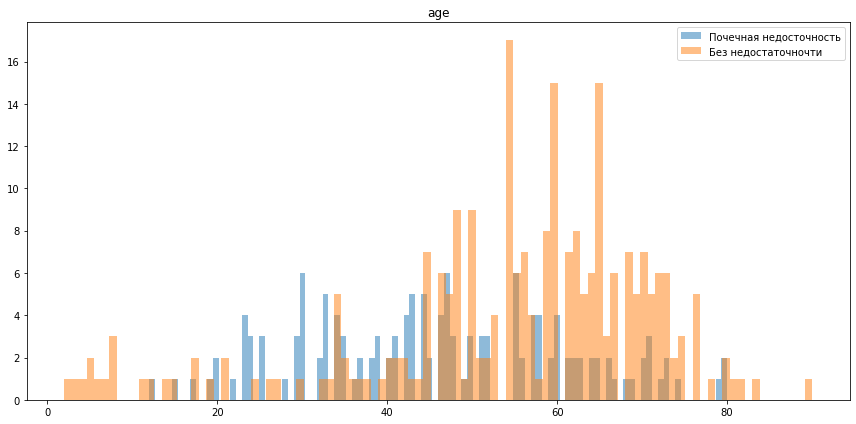

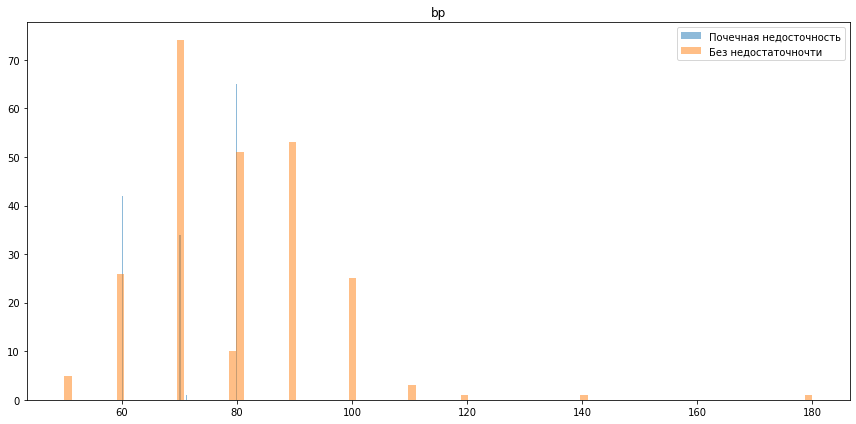

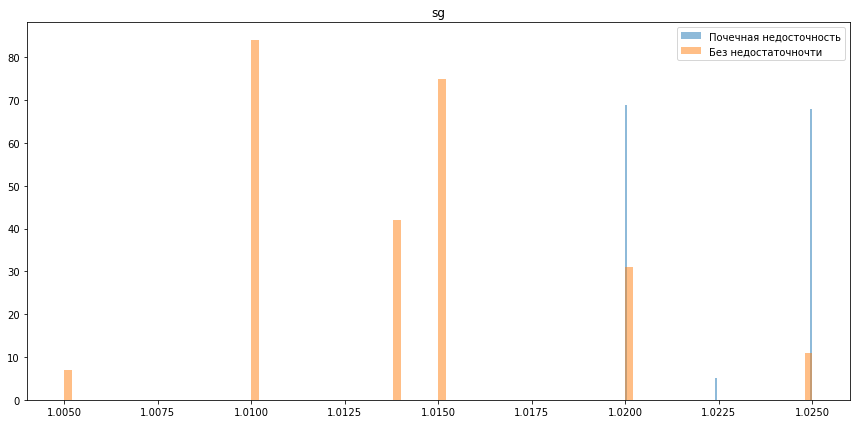

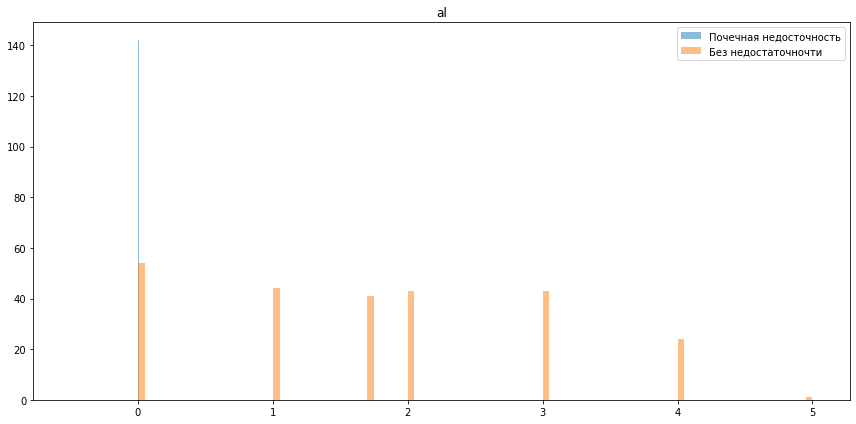

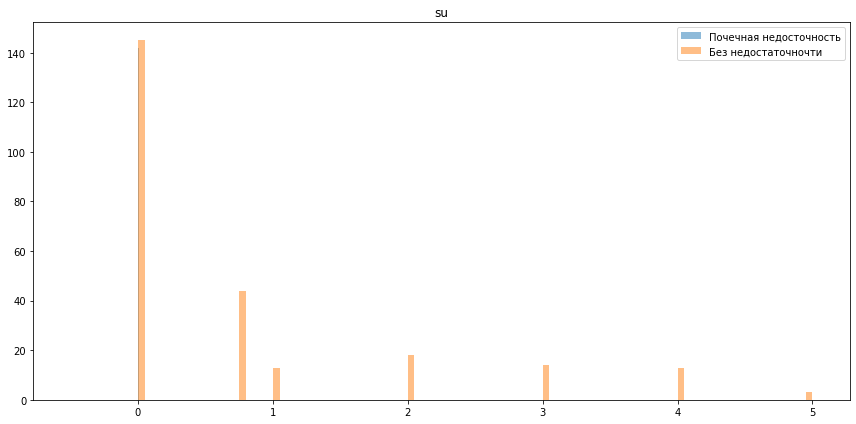

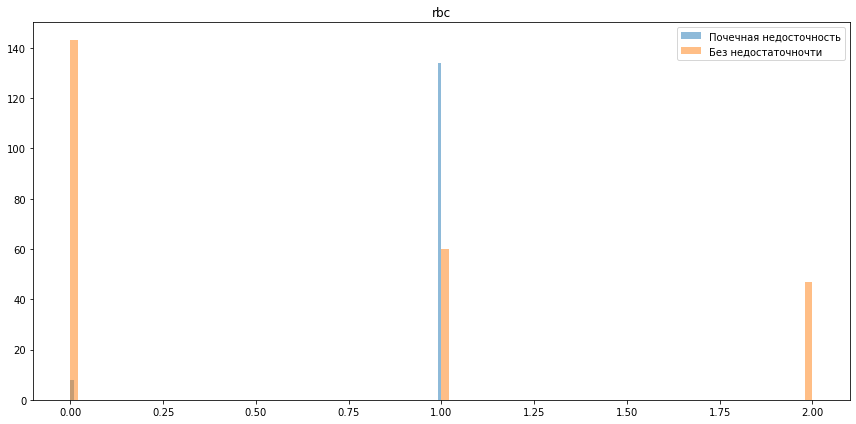

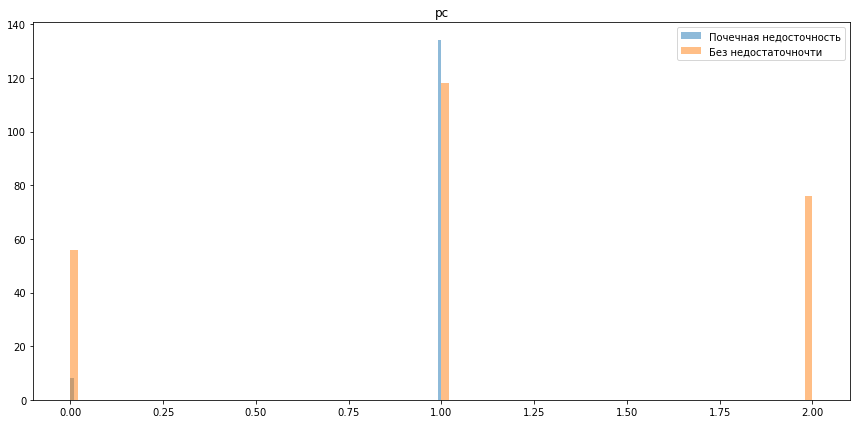

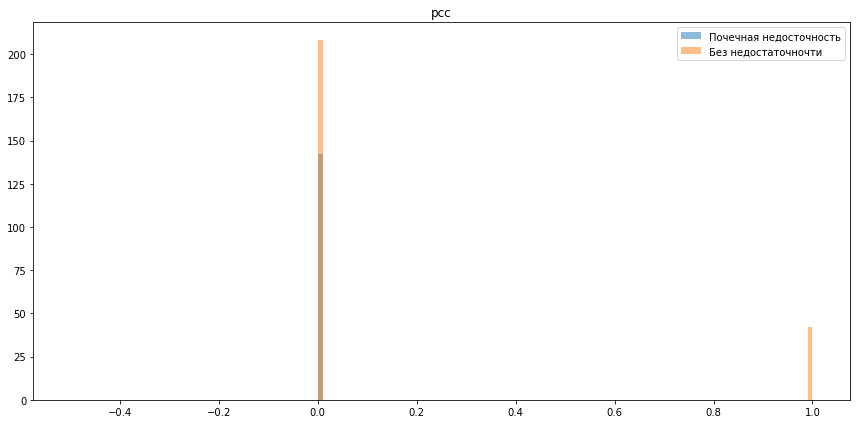

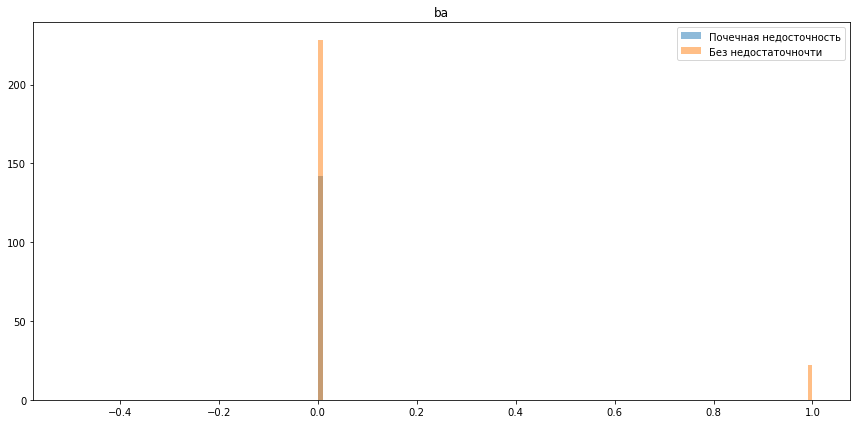

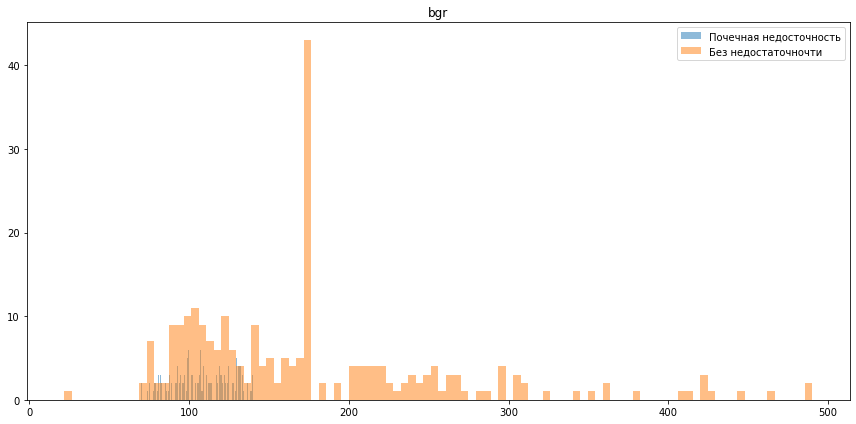

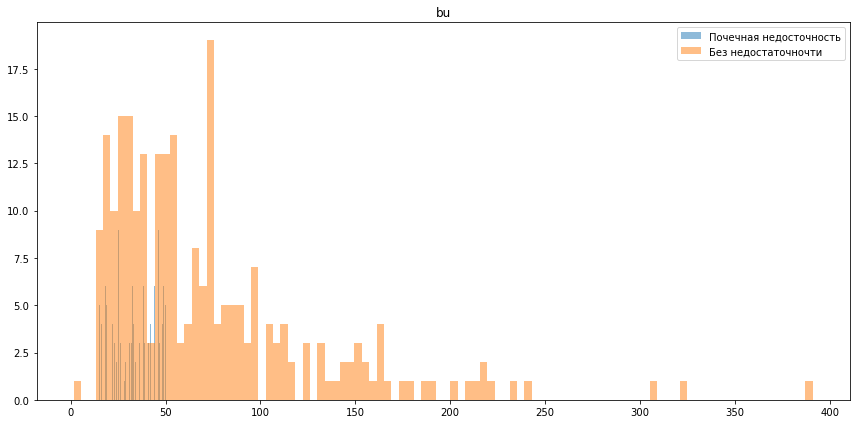

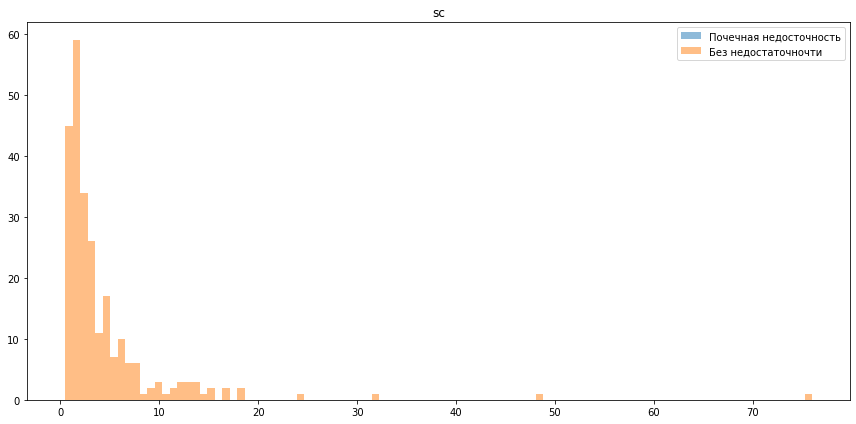

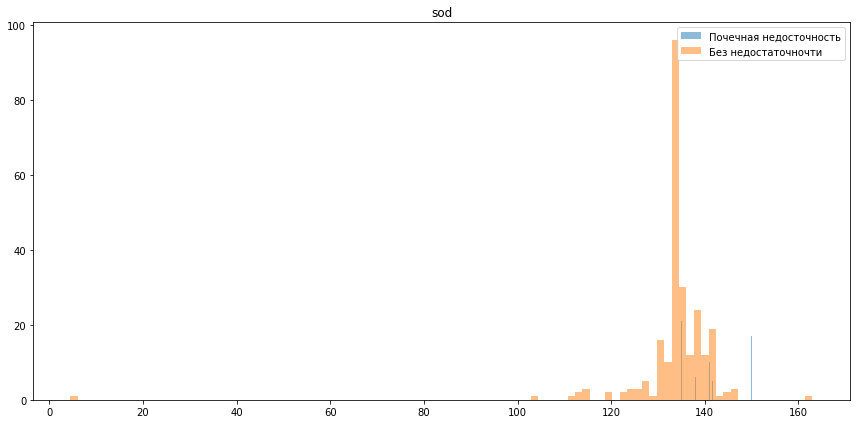

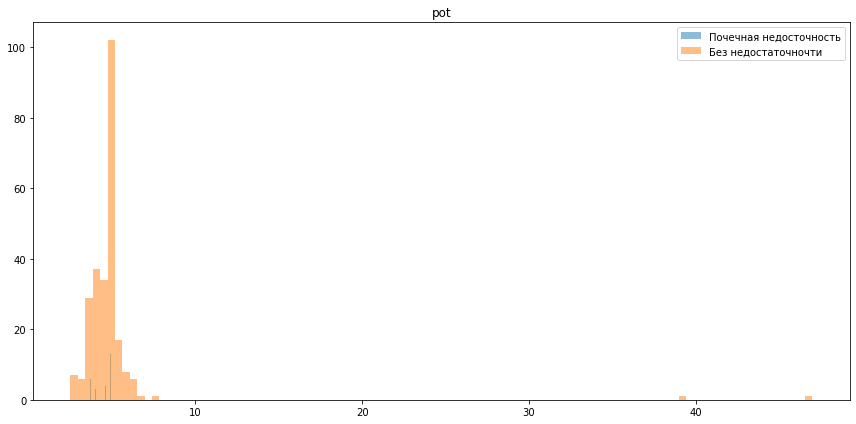

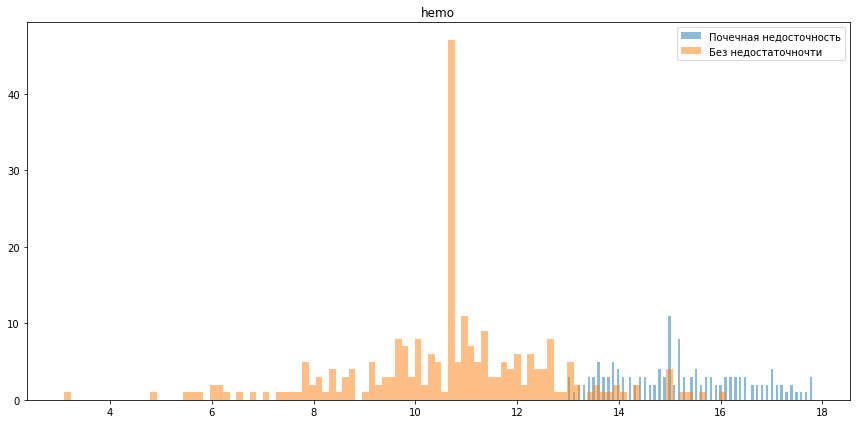

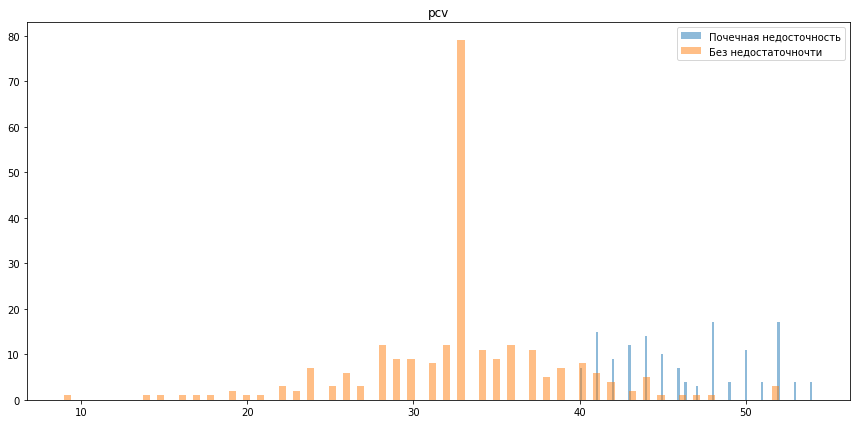

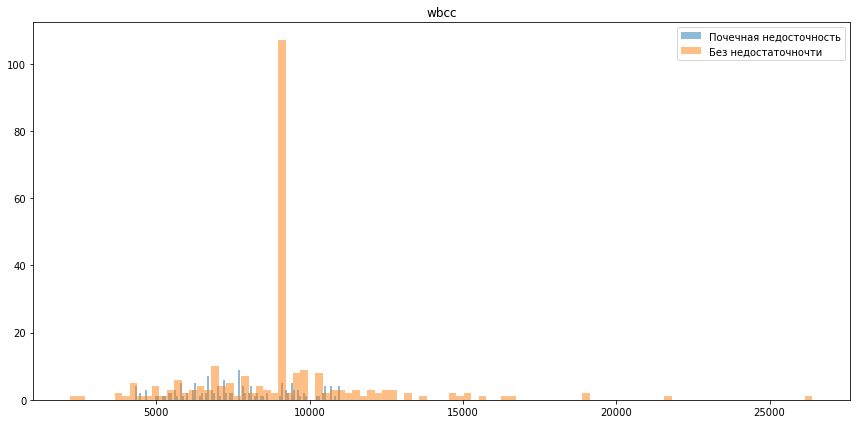

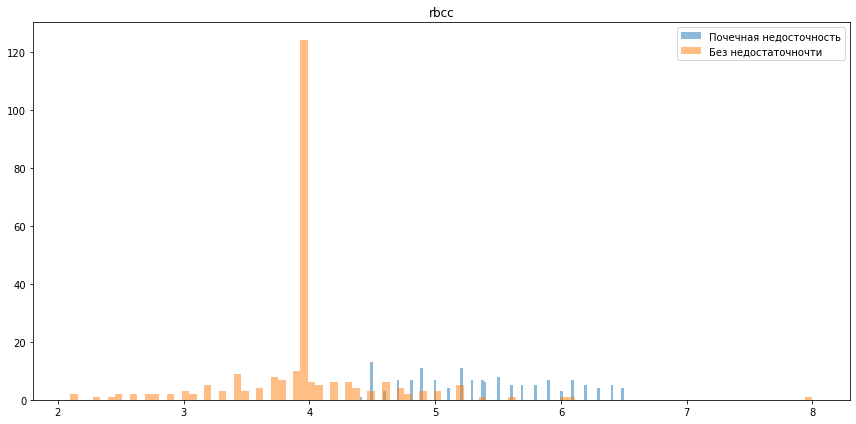

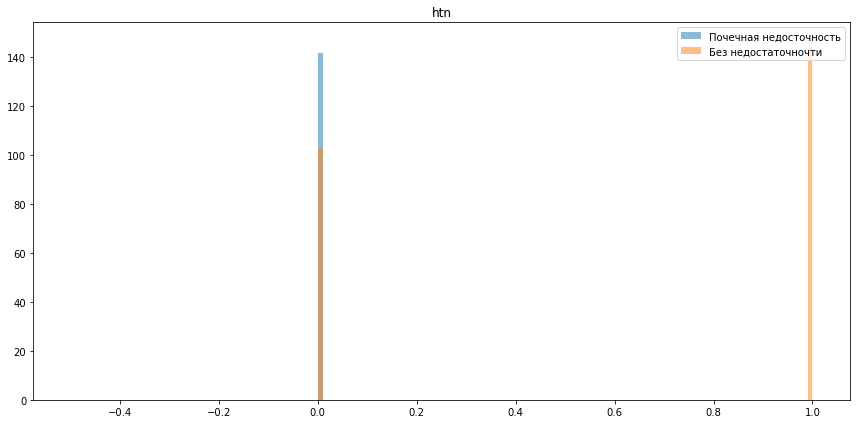

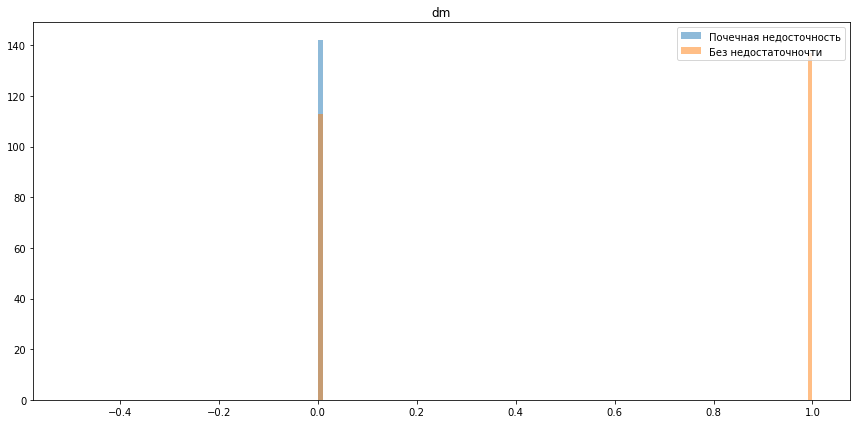

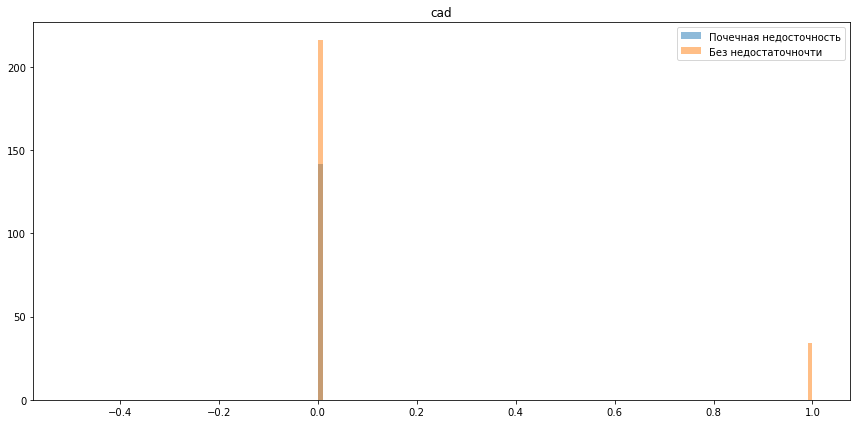

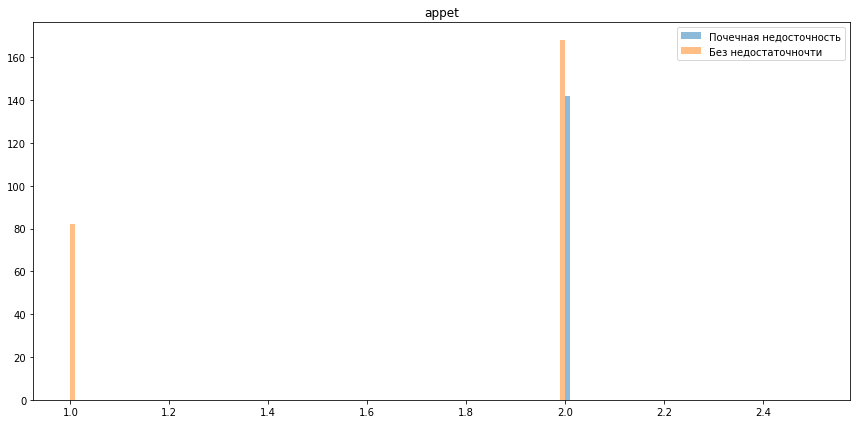

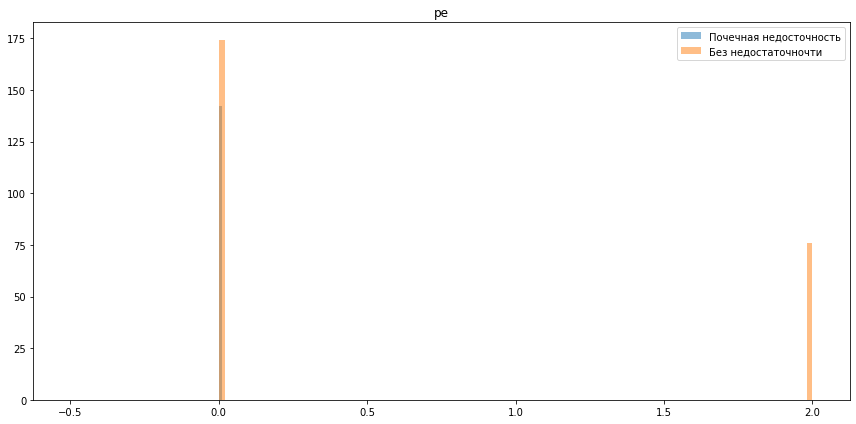

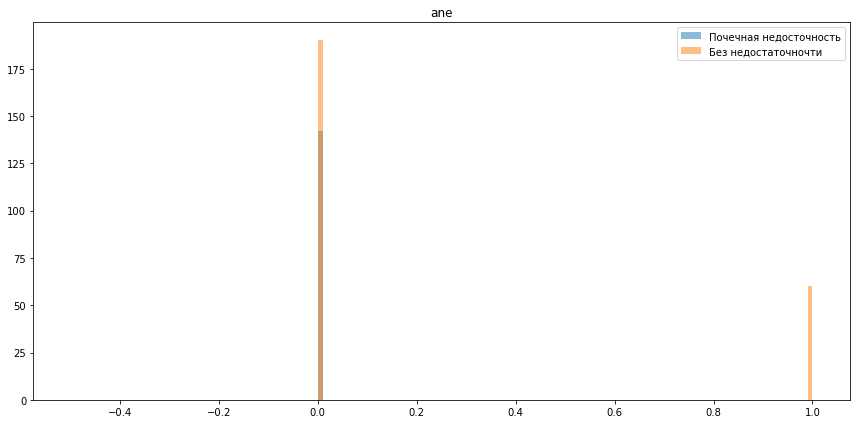

In [92]:
for feature in list(df.select_dtypes([np.number]).columns)[:-1]:
    feature_plot(feature)

Вычислим и отобразим матрицу корреляции между признаками:

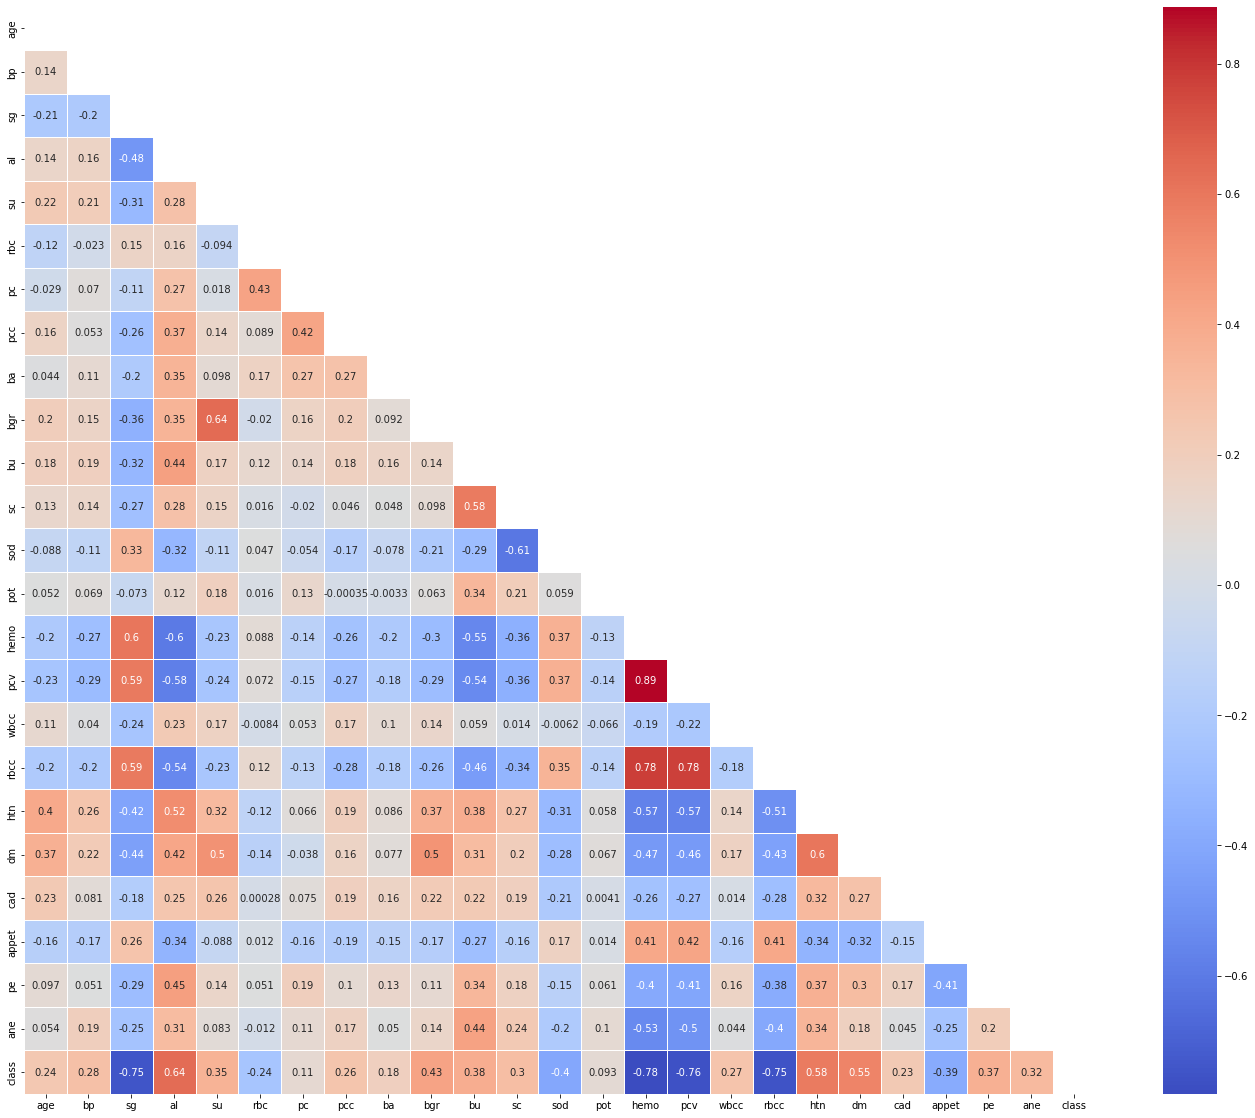

In [93]:
df_corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(24,20))
sns.heatmap(df_corr_matrix, annot=True, mask=np.triu(df_corr_matrix), cmap='coolwarm', linewidths=.5, ax=ax)
plt.show()

Для уменьшения количества признаков - удалим признаки с корреляцией меньше 0.5 (либо больше -0.5):

In [94]:
X=df.drop(['class', 'age', 'bp', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'pot', 'wbcc', 'cad', 'appet', 'pe', 'ane'], axis=1)
y=df[['class']]
scaler = MinMaxScaler()
scaler = scaler.fit(X)
X_normalized = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y.values.ravel(), test_size=0.3, random_state=1)

In [95]:
def model_scorer(model):
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    precision_positive = metrics.precision_score(y_test, predict, pos_label=1)
    precision_negative = metrics.precision_score(y_test, predict, pos_label=0)
    recall_sensitivity = metrics.recall_score(y_test, predict, pos_label=1)
    recall_specificity = metrics.recall_score(y_test, predict, pos_label=0)
    auc = metrics.roc_auc_score(y_test, predict)
    print('Метрики модели:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'Precision: {precision_positive, precision_negative}')
    print(f'Recall: {recall_sensitivity, recall_specificity}')
    print(f'AUC: {auc}')
    fpr, tpr, _ = metrics.roc_curve(y_test,  predict)
    plt.plot(fpr,tpr)
    plt.ylabel('Истинно-положительный результат')
    plt.xlabel('Ложно-положительный результат')
    plt.show()

После разбивки на тренировочный и тестовый наборы, построим модели с гиперпараметрами по-умолчанию и оценим их качество:

Метрики модели:
Accuracy: 0.9915254237288136
Precision: (0.9861111111111112, 1.0)
Recall: (1.0, 0.9787234042553191)
AUC: 0.9893617021276595


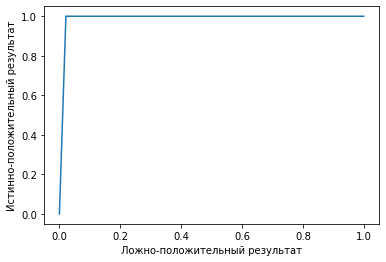

In [96]:
gb_defaut_model = GradientBoostingClassifier()
model_scorer(gb_defaut_model)

Метрики модели:
Accuracy: 1.0
Precision: (1.0, 1.0)
Recall: (1.0, 1.0)
AUC: 1.0


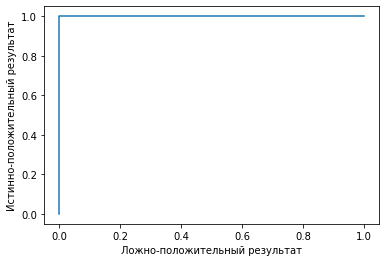

In [97]:
xgb_default_model = XGBClassifier()
model_scorer(xgb_default_model)

Метрики модели:
Accuracy: 1.0
Precision: (1.0, 1.0)
Recall: (1.0, 1.0)
AUC: 1.0


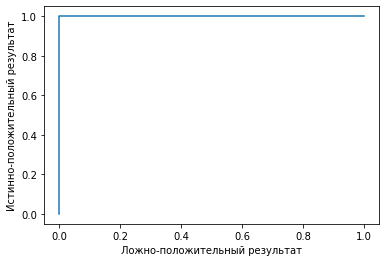

In [98]:
cb_default_model = CatBoostClassifier(logging_level='Silent')
model_scorer(cb_default_model)

Метрики модели:
Accuracy: 1.0
Precision: (1.0, 1.0)
Recall: (1.0, 1.0)
AUC: 1.0


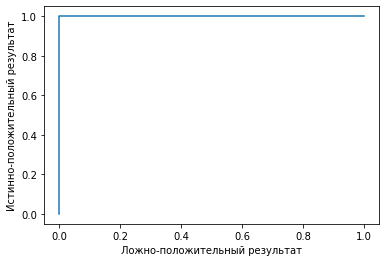

In [99]:
lgbm_default_model = LGBMClassifier()
model_scorer(lgbm_default_model)

Модели показали высокие значения метрик, проверим не переобучились ли модели:

In [100]:
cv = RepeatedStratifiedKFold(n_splits=37, n_repeats=3)

models_list = [gb_defaut_model, xgb_default_model, cb_default_model, lgbm_default_model]
for index, model in enumerate(models_list):
    res_acc = cross_val_score(model, X, y.values.ravel(), scoring='accuracy', cv=cv)
    res_r2 = cross_val_score(model, X, y.values.ravel(), scoring='r2', cv=cv)
    if index == 0:
        model_name = 'Gradient Boosting'
    elif index == 1:
        model_name = 'XGBoost'
    elif index == 2:
        model_name = 'CatBoost'
    elif index == 3:
        model_name = 'LightGBM'    
    print(f'Модель {model_name} accuracy: {mean(res_acc)} {std(res_acc)} R2: {mean(res_r2)} {std(res_r2)}')
    print('------------------------------------------------------------------------------')

Модель Gradient Boosting accuracy: 0.9932841932841933 0.027031742075001912 R2: 0.9777992277992279 0.09314361543649954
------------------------------------------------------------------------------
Модель XGBoost accuracy: 0.9940212940212941 0.02307257733169654 R2: 0.9757614757614758 0.10180752797391819
------------------------------------------------------------------------------
Модель Cat Boost accuracy: 0.9966420966420966 0.017383280324972255 R2: 0.9772629772629773 0.09555328514290584
------------------------------------------------------------------------------
Модель LightGBM accuracy: 0.9948402948402949 0.021610450542797074 R2: 0.9878807378807378 0.0730018005969404
------------------------------------------------------------------------------


После стратифицированной кросс-валидации можно сделать вывод, что самая точная модель получилась на алгоритме CatBoost, самая неточная - Gradient Boosting.

Согласно условия ДЗ проведем настройку базовых гиперпараметров моделей:

In [101]:
def CVModelTuner(input_model):
    cv = GridSearchCV(input_model, parameters, cv=5)
    cv.fit(X, y.values.ravel())
    return cv.best_params_

In [102]:
parameters = {
    "n_estimators": [5, 50, 250, 500],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [1e-5, 1e-4, 1e-3, 0.01] #, 0.1, 1, 10, 100
}

In [103]:
models_list = [gb_defaut_model, xgb_default_model, cb_default_model, lgbm_default_model]
best_params_list = []
for index, model in enumerate(models_list):
    if index == 0:
        model_name = 'Gradient Boosting'
    elif index == 1:
        model_name = 'XGBoost'
    elif index == 2:
        model_name = 'CatBoost'
    elif index == 3:
        model_name = 'LightGBM'    
    print(f'Модель {model_name}:')
    best_params = CVModelTuner(model)
    best_params_list.append(best_params)
    print(f'Лучшие гиперпараметры: {best_params}')
    print('------------------------------------------------------------------------------')

Модель Gradient Boosting:
Лучшие гиперпараметры: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 250}
------------------------------------------------------------------------------
Модель XGBoost:
Лучшие гиперпараметры: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500}
------------------------------------------------------------------------------
Модель Cat Boost:
Лучшие гиперпараметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
------------------------------------------------------------------------------
Модель LightGBM:
Лучшие гиперпараметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
------------------------------------------------------------------------------


Проведем оценку моделей с самыми оптимальными гиперпараметрами:

In [104]:
gb_defaut_model_tuned = GradientBoostingClassifier(**best_params_list[0])
xgb_default_model_tuned = XGBClassifier(**best_params_list[1])
cb_default_model_tuned = CatBoostClassifier(**best_params_list[2], logging_level='Silent')
lgbm_default_model_tuned = LGBMClassifier(**best_params_list[3])

In [105]:
cv = RepeatedStratifiedKFold(n_splits=37, n_repeats=3)

models_list = [gb_defaut_model_tuned, xgb_default_model_tuned, cb_default_model_tuned, lgbm_default_model_tuned]
for index, model in enumerate(models_list):
    res_acc = cross_val_score(model, X, y.values.ravel(), scoring='accuracy', cv=cv)
    res_r2 = cross_val_score(model, X, y.values.ravel(), scoring='r2', cv=cv)
    if index == 0:
        model_name = 'Gradient Boosting'
    elif index == 1:
        model_name = 'XGBoost'
    elif index == 2:
        model_name = 'CatBoost'
    elif index == 3:
        model_name = 'LightGBM'    
    print(f'Модель {model_name} accuracy: {mean(res_acc)} {std(res_acc)} R2: {mean(res_r2)} {std(res_r2)}')
    print('------------------------------------------------------------------------------')

Модель Gradient Boosting accuracy: 0.9914004914004916 0.027363698614099215 R2: 0.975010725010725 0.10983154585910129
------------------------------------------------------------------------------
Модель XGBoost accuracy: 0.9939393939393939 0.023387887340801043 R2: 0.9766194766194767 0.09809017648753535
------------------------------------------------------------------------------
Модель Cat Boost accuracy: 0.9974610974610975 0.015249698482474169 R2: 0.9886314886314886 0.06851611636350023
------------------------------------------------------------------------------
Модель LightGBM accuracy: 0.9973791973791973 0.015740590640510907 R2: 0.9893822393822395 0.0637065637065637
------------------------------------------------------------------------------


После настройки гиперпараметров лидером так и осталась CatBoost, ее точность незначительно, но выросла.